<a href="https://colab.research.google.com/github/daviddkovacs/Global-EVT-maps/blob/main/codes/Local_DKovacs_MOGPR_manaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install GPy

from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from datetime import datetime
import osgeo.ogr
import json
import sys
import pickle
import GPy
import h5py
import math
from scipy.stats import pearsonr
import csv
from shapely.geometry import box
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import os
import seaborn as sns
import matplotlib.ticker as ticker
import traceback
from datetime import timedelta
import shapely
from shapely.geometry import mapping
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 9.0 MB/s eta 0:00:00
Mounted at /content/drive


In [16]:
def create_empty_2D_list(nrows,ncols):

    empty_list = []
    for j in range(nrows):
        column = []
        for i in range(ncols):
            column.append(0)
        empty_list.append(column)
    return empty_list

def datestr_to_number(time_vec):
    """
    Function coverting date vector from string to absolute number vector

    Args:
        time_vec [list] : Date vector in list-of-string format

    Returns:
        time_vec_num [array]: Date vector in array format

    """
    time_vec_num = [ _.toordinal() for _ in time_vec]
    return time_vec_num

def number_to_datestr(time_vec_num):

    """
    Function coverting date vector from string to absolute number vector
    """

    time_vec = [datetime.fromordinal(int(_)) for _ in time_vec_num]
    return time_vec


def GPY_retrieval_Noutput(DATA,TIME,Master_Ind,output_timevec,Nt,proc_line_print ='MOGPR modelling..',W_rank=1, trained_model=[]):
    """
    Function performing the multioutput gaussian-process regression at pixel level for gapfilling and temporal reconstruction purposes

    Args:
        DATA [array] : 3D (2DSpace, Time) array containing data to be processed
        TIME [array] : vector containing the dates of each layer in the time dimension
        Master_Ind [int] : Index identifying the Master output
        output_timevec [array] :vector containing the dates on which output must be estimated
        Nt [int]  : # of time the GP training must be performed (def=1)

    """

    noutput_timeseries = len(DATA)

    x_size = DATA[0].shape[1]
    y_size = DATA[0].shape[2]
    imout_sz = (output_timevec.shape[0],x_size,y_size)

    Xtest     = output_timevec.reshape(output_timevec.shape[0],1)
    Out_QFlag = np.ones((x_size,y_size), dtype=bool)
    Out_mean  = []
    Out_unc   = []
    Out_model = create_empty_2D_list(x_size,y_size)

    for _ in range(noutput_timeseries):
        Out_mean.append(np.full(imout_sz,np.nan))
        Out_unc.append(np.full(imout_sz,np.nan))

    model_parameter_names = None
    cnt = 0
    tot = x_size*y_size
    check_param_names_flag= True

    for x, y in itertools.product(range(x_size), range(y_size)):

            X_vec = []
            Y_vec = []
            Y_mean_vec = []
            Y_std_vec  = []

            for ind in range(noutput_timeseries):

              #X_tmp  = np.array(TIME[ind],dtype=np.float128)
              #Y_tmp  =np.array( DATA[ind][:,x,y],dtype=np.float128)
              X_tmp  = TIME[ind]
              Y_tmp  = DATA[ind][:,x,y]
              X_tmp  = X_tmp[~np.isnan(Y_tmp),np.newaxis]
              Y_tmp  = Y_tmp[~np.isnan(Y_tmp),np.newaxis]
              X_vec.append(X_tmp)
              Y_vec.append(Y_tmp)
              del X_tmp,Y_tmp


            if np.size(Y_vec[Master_Ind]) >0:

                # Data Normalization
                for ind in range(noutput_timeseries):
                    Y_mean_vec.append(np.mean(Y_vec[ind]))
                    Y_std_vec.append(np.std(Y_vec[ind]))
                    Y_vec[ind] = (Y_vec[ind]-Y_mean_vec[ind])/Y_std_vec[ind]

                # Multi-output training and testing sets
                Xtrain = X_vec
                Ytrain = Y_vec

                nsamples, npixels = Xtest.shape
                noutputs = len(Ytrain)

                for i_test in range(Nt):

                    Yp = np.zeros((nsamples, noutputs))
                    Vp = np.zeros((nsamples, noutputs))

                    # Use RBF (Radial Basis Function) or Matern32 as kernels.
                    # The RBF accounts for more noise
                    # variance and lengthscale are the hyperparameters to optimise.
                    # larger variance will account for more noise, lower lengthscale will account for more noise as well.

                    K            =  GPy.kern.RBF(Xtrain[0].shape[1],variance=1,lengthscale=1,ARD=True,)

                    LCM          =  GPy.util.multioutput.LCM(input_dim    =  Xtrain[0].shape[1],
                                                             num_outputs  =  noutputs,
                                                             kernels_list =  [K] * noutputs, W_rank=W_rank)

                    model = GPy.models.GPCoregionalizedRegression(Xtrain, Ytrain, kernel=LCM.copy())  # , W_rank=noutputs)
                    # model['.*Mat32.var'].constrain_fixed(1.)

                    if not np.isnan(Ytrain[1]).all():

                            try:
                                #if trained_model is None:
                                model.optimize()
                                #else:
                                    #here we should iterate through the model's parameters to assigned the pretrained values
                                   # model = 1

                                list_tmp = [model.param_array]

                                for _ in range(noutput_timeseries):
                                    #print('model.sum.ICM'+str(_)+'.B.B')
                                    list_tmp.append(eval('model.sum.ICM'+str(_)+'.B.B'))
                                Out_model[x][y]=list_tmp
                                # list_tmp contains [model.param_array, model.sum.ICM0.B.B,model.sum.ICM1.B.B])

                                if check_param_names_flag:
                                    model_parameter_names = model.parameter_names()
                                    check_param_names_flag=False
                            except:
                                Out_QFlag[x,y]=False
                                continue


                            for out in range(noutputs):
                                newX = Xtest.copy()

                                newX = np.hstack([newX, out * np.ones((newX.shape[0], 1))])
                                noise_dict = {'output_index': newX[:, -1:].astype(int)}
                                Yp[:,None, out],Vp[:,None,out] =model.predict(newX, Y_metadata=noise_dict)

                            if i_test==0:

                                for ind in range(noutput_timeseries):
                                    Out_mean[ind][:,None,x,y] = (Yp[:,None, 0]*Y_std_vec[ind]+Y_mean_vec[ind])/Nt
                                    Out_unc[ind][:,None,x,y]  = (Vp[:,None, 0]*Y_std_vec[ind])/Nt

                            else:
                                for ind in range(noutput_timeseries):
                                    Out_mean[ind][:,None,x,y] = Out_mean[ind][:,None,x,y] + (Yp[:,None, 0]*Y_std_vec[ind]+Y_mean_vec[ind])/Nt
                                    Out_unc[ind][:,None,x,y]  = Out_unc[ind][:,None,x,y]  + (Vp[:,None, 0]*Y_std_vec[ind])/Nt

                            del Yp,Vp
    if check_param_names_flag:
        print('\n')
        print("******************************************************************************************")
        print("No model has been trained within the processed block (probably due to non-valid input data)".upper())
        print("Processing is skippped to next block!".upper())
        print("******************************************************************************************")
        print('\n')

    return  Out_mean, Out_unc, Out_QFlag, Out_model,model_parameter_names

In [51]:
mana_df_wfr = pd.read_excel("/content/drive/MyDrive/Munka/CNES/Data/manacapuru.xlsx","wfr")
S3_start_year = 2016
S3_end_year = 2020

con_start_year = 2016
con_end_year = 2018



#S3
qf = mana_df_wfr.iloc[:, mana_df_wfr.columns.get_loc("Quality")].tolist()

S3_SPM = mana_df_wfr.iloc[:, mana_df_wfr.columns.get_loc("SPM.avg")].tolist()
S3_SPM = [S3_SPM[i] for i in range(len(qf)) if qf[i] == 1]

S3_date = mana_df_wfr.iloc[:, mana_df_wfr.columns.get_loc("Datetime")].tolist()
S3_date = [S3_date[i] for i in range(len(qf)) if qf[i] == 1]


filtered_list_S3 = [(timestamp, data) for timestamp, data in zip(S3_date,S3_SPM) if timestamp >= datetime(S3_start_year, 1, 1) and timestamp <= datetime(S3_end_year, 1, 1)]
S3_date, S3_SPM = zip(*filtered_list_S3)

# Concentração
mana_df_con = pd.read_excel("/content/drive/MyDrive/Munka/CNES/Data/manacapuru.xlsx","sedimentos")

con = mana_df_con.iloc[:, mana_df_con.columns.get_loc("Concentração (mg/L)")].tolist()

con_date = mana_df_con.iloc[:, mana_df_con.columns.get_loc("Data")].tolist()

sorted_con = sorted(zip(con_date,con))

filtered_list_con = [(timestamp, data) for timestamp, data in sorted_con if timestamp >= datetime(con_start_year, 1, 1) and timestamp <= datetime(con_end_year, 1, 1)]

concentracao_date, concentracao  = zip(*filtered_list_con) # Since the dates are all over the place, we sort them increasingly

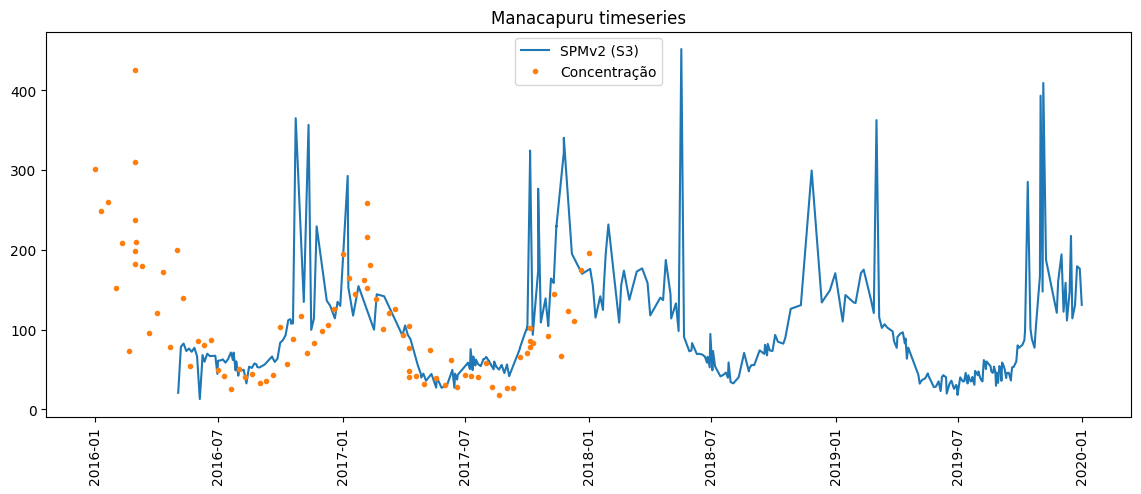

In [52]:
plt.rcParams["figure.figsize"] = (14,5)  # Default [6.4, 4.8]
plt.title('Manacapuru timeseries')
plt.plot(S3_date,S3_SPM,label='SPMv2 (S3)')
plt.plot(concentracao_date,concentracao,".",label='Concentração')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [53]:
dates1 = np.array(S3_date)
timeseries1 = np.array(S3_SPM)
dates2 = np.array(concentracao_date)
timeseries2 = np.array(concentracao)

In [54]:
from datetime import datetime
import numpy as np

# one of my worst nightmares was doing this. but it works. dont ask how and why.
ts1 = [(x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') for x in dates1]
utc1 = np.array([datetime.utcfromtimestamp(x).toordinal() for x in ts1], dtype=object)

ts2 = [(x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's') for x in dates2]
utc2 = np.array([datetime.utcfromtimestamp(x).toordinal() for x in ts2], dtype=object)

In [55]:
DATA_v2 = [] #List containing two arrays, the two variables that you fuse
DATA_v2.append(np.reshape(timeseries1,(timeseries1.shape[0],1,1)))
DATA_v2.append(np.reshape(timeseries2,(timeseries2.shape[0],1,1)))


TIME_v2 = [] #List containing two arrays, the two variables' DATES that you fuse
TIME_v2.append(utc1)
TIME_v2.append(utc2)

TIME_str = [] # List containing times of observation in datetime format
TIME_str.append(np.array([datetime.utcfromtimestamp(x) for x in ts1]))
TIME_str.append(np.array([datetime.utcfromtimestamp(x) for x in ts2]))

In [56]:
Nt =1
Master_Ind = 0

Time_step      = 2 # Temporal composites. The algorithm will create fused data of the two variables, and "composite" it in the number of days you define

time_vec_MIN        = np.min(list(pd.core.common.flatten(TIME_v2)))
time_vec_MAX        = np.max(list(pd.core.common.flatten(TIME_v2)))
output_timevec      = np.array(range(int(time_vec_MIN),int(time_vec_MAX),Time_step),dtype=float)
# output_timevec      = np.array(range(int(time_vec_MIN),int(time_vec_MAX),Time_step),dtype=int)
output_time         = number_to_datestr(output_timevec)
outputs_timevec_str =[ _.strftime("%Y%m%d") for _ in output_time]

print('MULTIOUTPUT Being calculated, please wait')

### MAIN FUNCTION ###

Out_mean, Out_unc, Out_QFlag, Out_model,model_parameter_names = GPY_retrieval_Noutput(DATA_v2[:],TIME_v2[:],Master_Ind,output_timevec,
                                                                                            Nt,proc_line_print ='MOGPR modelling..')

MULTIOUTPUT Being calculated, please wait


The next cell is only for plotting
The dates are not converted to date format, and still being used as datetime vectors

<Figure size 2500x600 with 0 Axes>

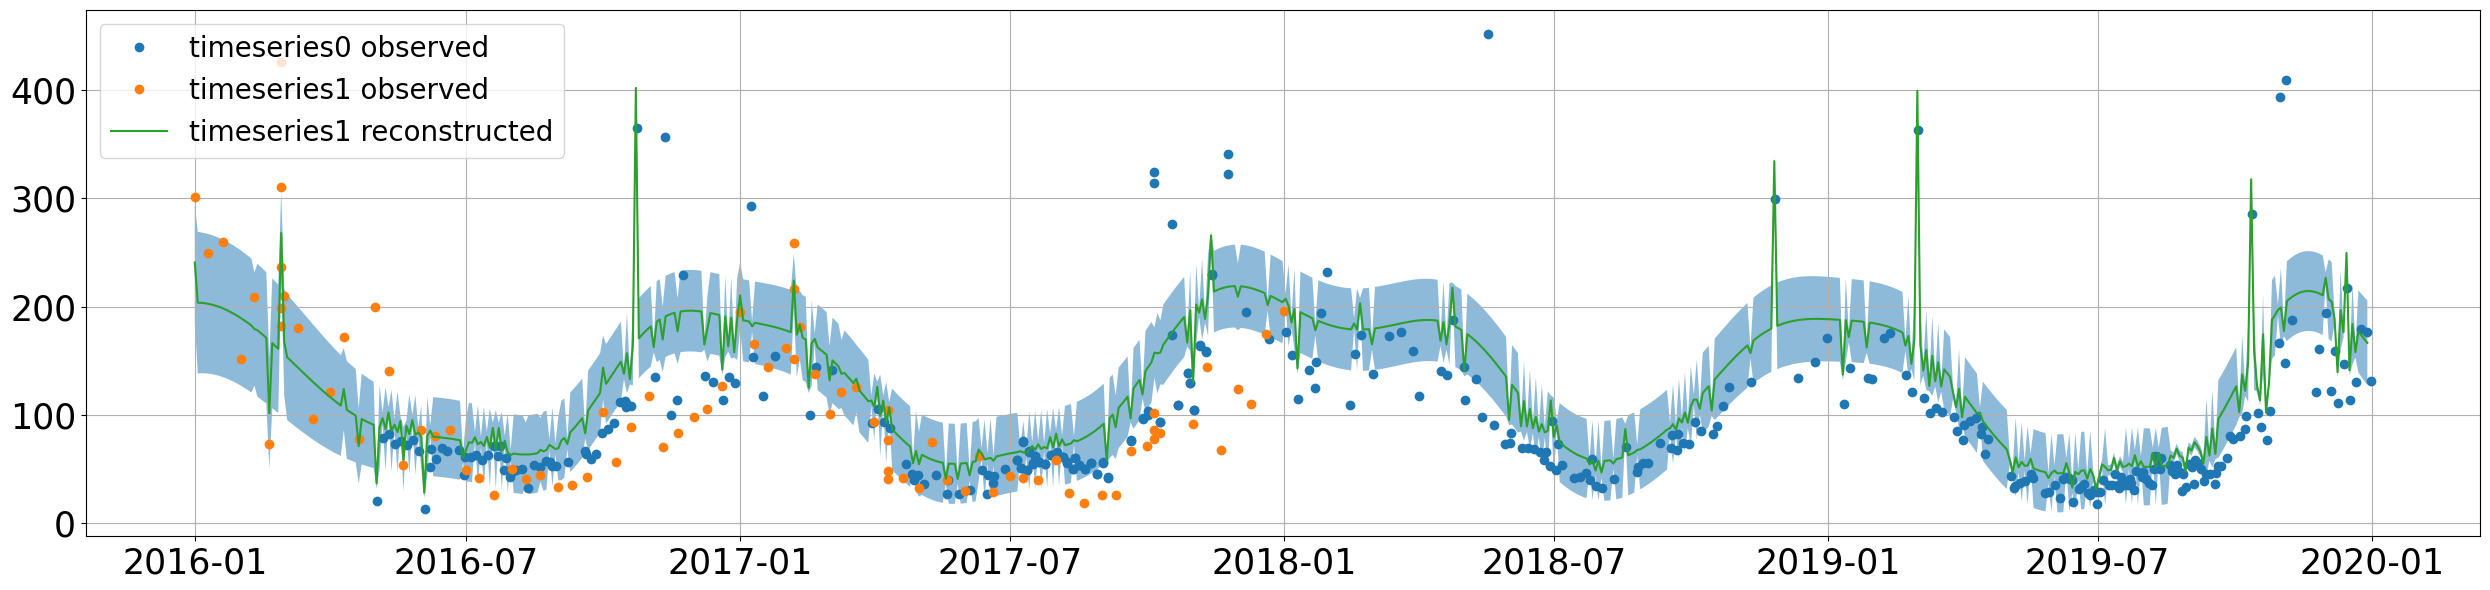

In [57]:
plt.figure(figsize= (25,6))

number_sensor_inputs = len(DATA_v2)
# for number in range(number_sensor_inputs):
#     p1 = plt.plot_date(TIME_str[number],DATA_v2[number].ravel(),"o",label = "timeseries" + str(number) + " observed")

# p2 = plt.plot_date(output_time, Out_mean[0].ravel(),"-",label = "timeseries" + str(0) +" reconstructed")
# plt.fill_between(output_time, Out_mean[0].ravel()+Out_unc[0].ravel(),
#                 Out_mean[0].ravel()-Out_unc[0].ravel(), alpha=0.5)


# fontsize = 25

# plt.yticks(fontsize=fontsize)
# plt.xticks(fontsize=fontsize)
# plt.ylabel("",fontsize=fontsize)
# plt.grid(True)
# plt.tight_layout()
# plt.legend(fontsize=20)
# plt.show()

plt.figure(figsize= (25,6))

for number in range(number_sensor_inputs):
    p1 = plt.plot_date(TIME_str[number],DATA_v2[number].ravel(),"o",label = "timeseries" + str(number) + " observed")

p3 = plt.plot_date(output_time, Out_mean[1].ravel(),"-",label = "timeseries" + str(1) +" reconstructed")
plt.fill_between(output_time, Out_mean[1].ravel()+Out_unc[1].ravel(),
                    Out_mean[1].ravel()-Out_unc[1].ravel(), alpha=0.5)

fontsize = 25

plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.ylabel("",fontsize=fontsize)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=20)
plt.show()